In [1]:
import pprint

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import numpy as np
import pathlib

ROOT = pathlib.Path('../data')

def recover_python_datatypes(element):
  if isinstance(element, str):
    if element.startswith('[') and element.endswith(']'):
      if ',' in element:
        element = np.fromstring(element[1:-1], dtype=float, sep=',')
      else:
        element = np.fromstring(element[1:-1], dtype=float, sep=' ')
  return element

def load_results(result_name):
  """Load a result file.
  
  The first line in the result files specify the index columns,
  the following lines are a CSV formatted file containing the
  numerical results.
  """
  results = {}
  for result_csv in (ROOT / result_name).glob('*.csv'):
    with open(result_csv) as fh:
      index_names = fh.readline().strip().split(',')
      df = pd.read_csv(fh).set_index(index_names)
      df = df.applymap(recover_python_datatypes)
      results[result_csv.stem] = df
  return results   
    
results = load_results(result_name = 'results_v4')
len(results)

8

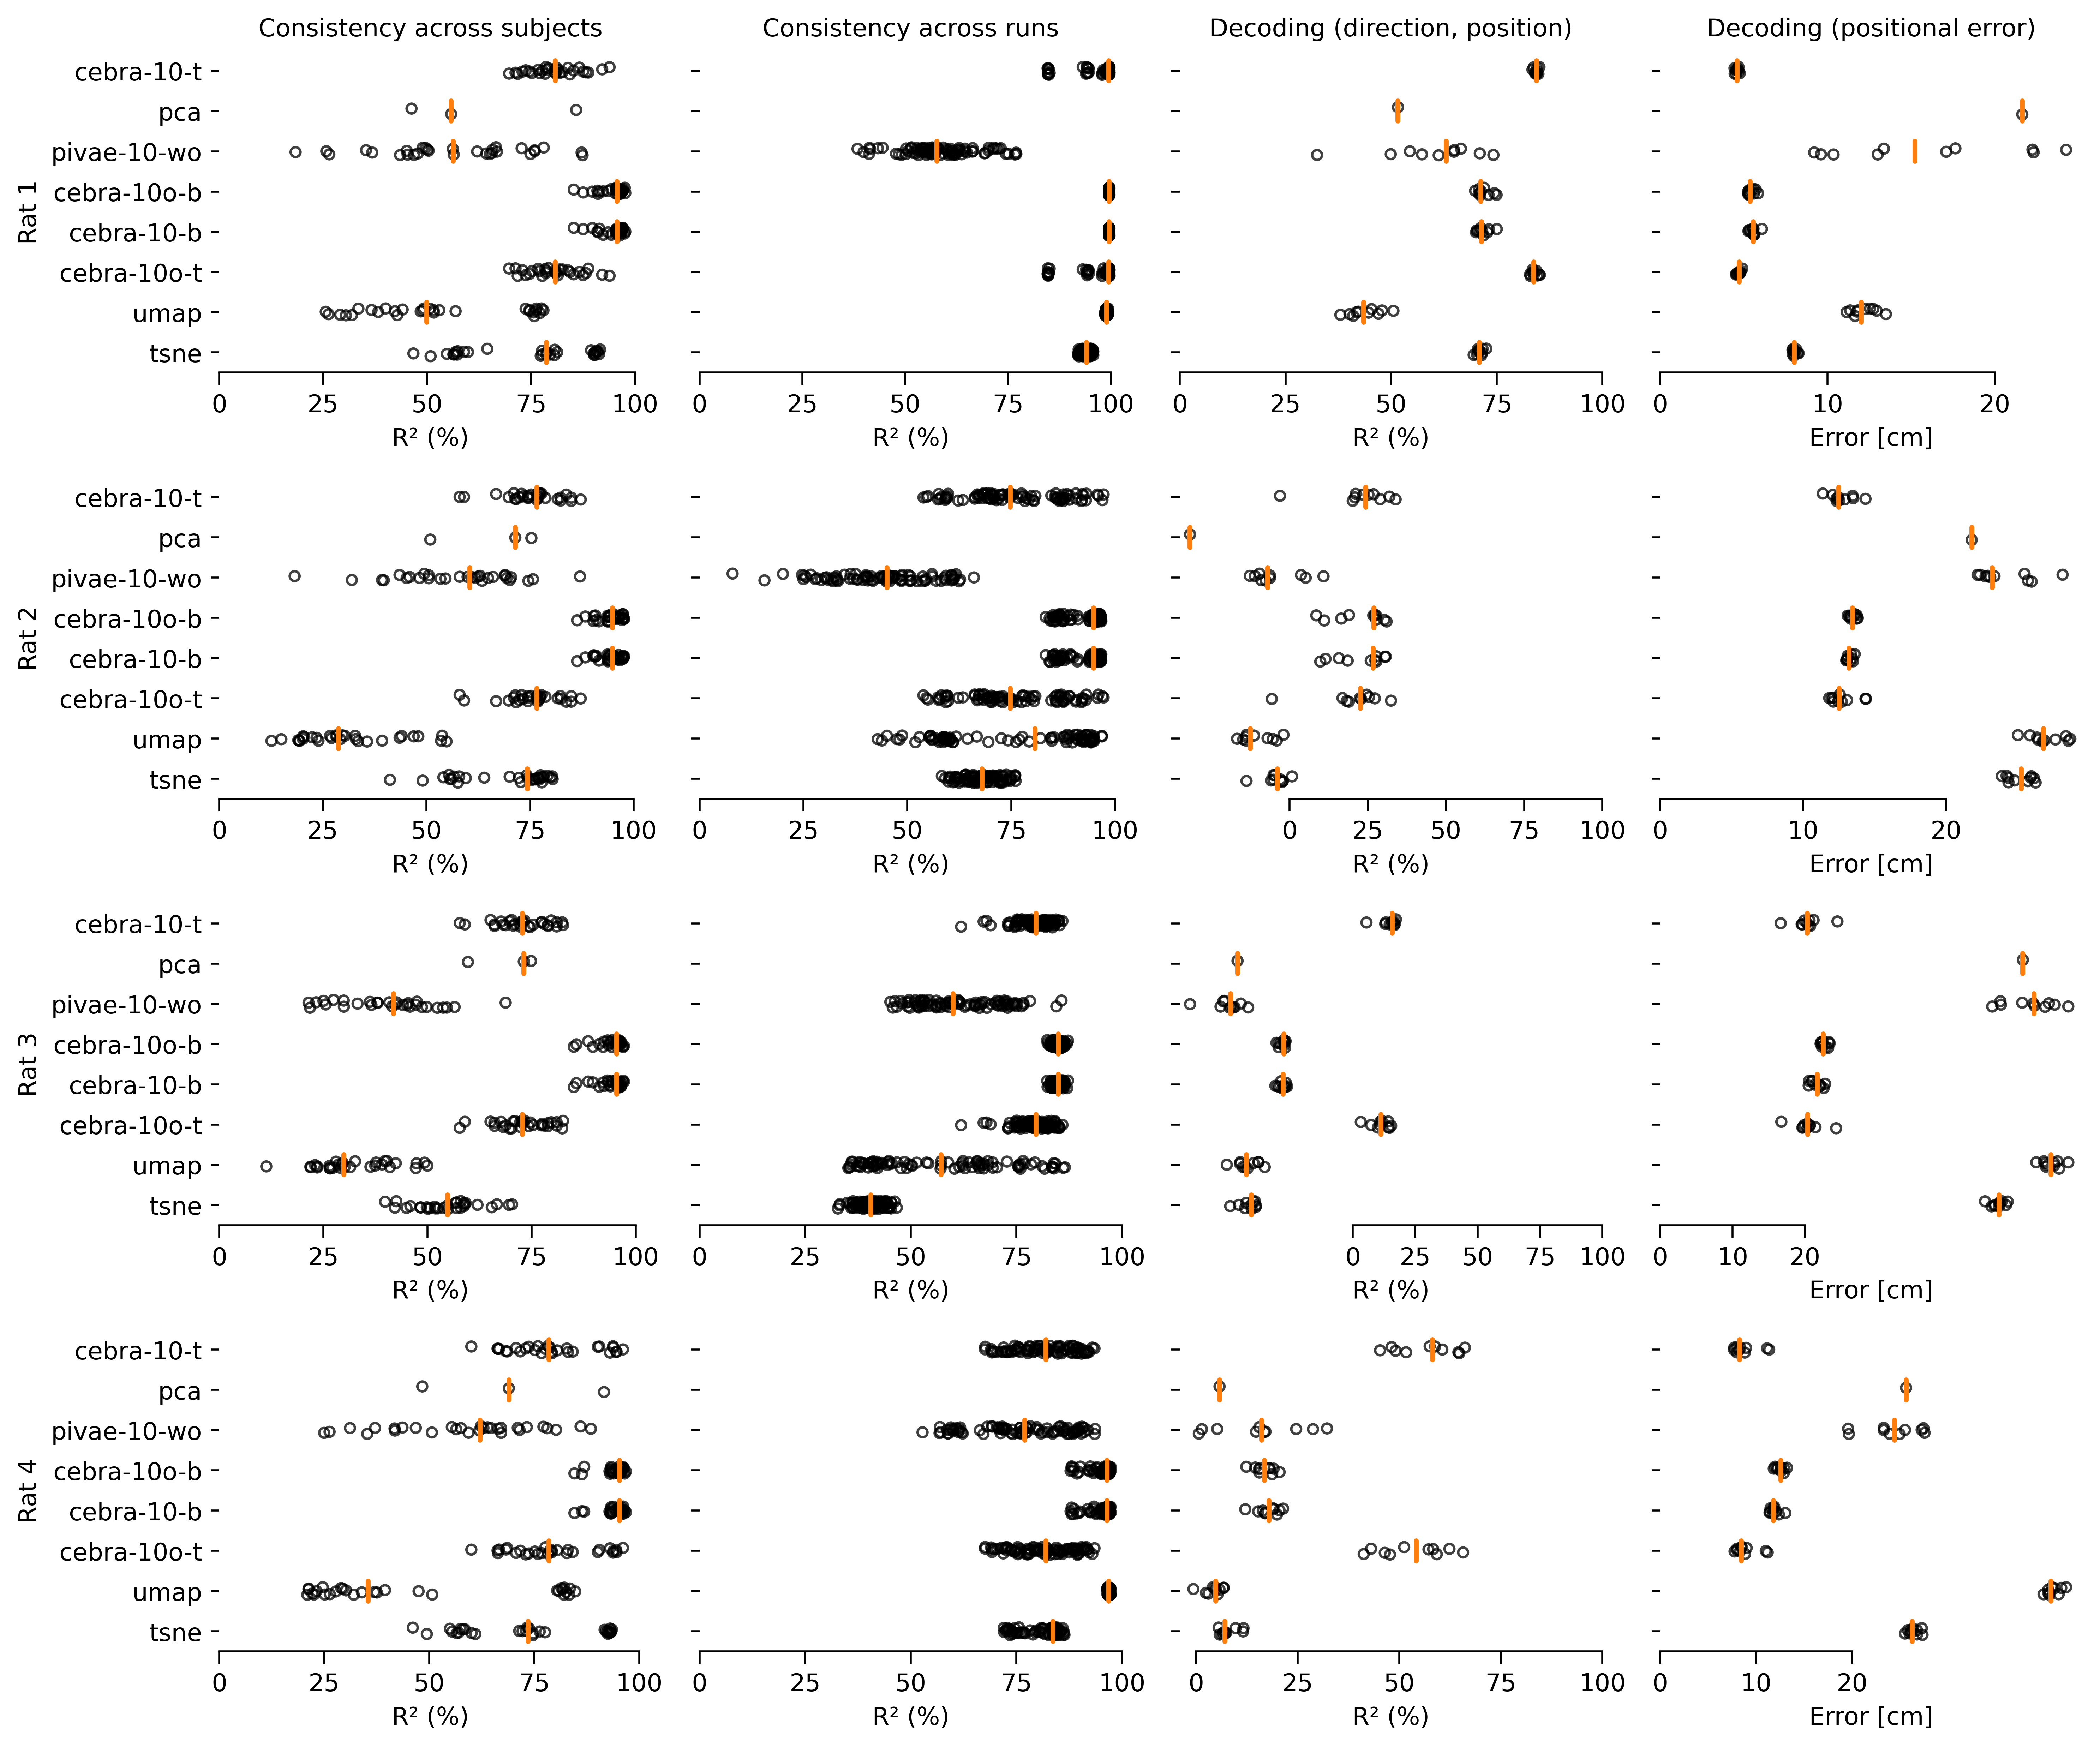

In [3]:
"""Fine-grained plots for consistency and decoding across all animals and algorithms

Supplementary figure.
"""

from matplotlib.markers import MarkerStyle
import warnings
import typing

def show_boxplot(df, metric, ax, labels = None):

  sns.set_style("white")
  
  with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    color = 'C1'
    sns.boxplot(
        data = df,
        y = 'method',
        x = metric,
        orient = 'h',
        order = labels, #unique(labels.values()),
        #hue = "rat",
        width = .5,
        color = 'k',
        linewidth = 2,
        flierprops = dict(alpha = .5, markersize = 0, marker = '.', linewidth = 0),
        medianprops = dict(c = 'C1', markersize = 0, marker = '.', linewidth = 2, solid_capstyle='round'),
        whiskerprops = dict(solid_capstyle='butt', linewidth = 0),
        #capprops = dict(c = 'C1', markersize = 0, marker = 'o', linewidth = 1),
        showbox=False, showcaps=False,
        #shownotches = True
        ax = ax,

    )
    marker_style = MarkerStyle("o", "none")
    
    sns.stripplot(
      data = df,
      y = 'method',
      x = metric,
      orient = 'h',
      size = 4,
      color = "black",
      order = labels,
      marker = marker_style,
      linewidth = 1,
      ax = ax,
      alpha = 0.75,
      jitter = 0.1,
      zorder = -1,
    )
    #sns.despine(left = True, ax = ax)
    #ax.get_legend().remove()
    ax.set_ylabel("")
    sns.despine(left = True, bottom = False, ax = ax)
    #ax.tick_params(axis = 'x', length = 2, colors = "black")
    ax.tick_params(
      axis='x',
      which='both',
      bottom=True,
      top=False,
      length = 5,
      labelbottom=True)
    return ax

def _add_value(df, **kwargs):
  for key, value in kwargs.items():
    df[key] = value
  return df

def join(results):
  return pd.concat([_add_value(df, method = key) for key, df in results.items()])

import seaborn as sns
import matplotlib.pyplot as plt
import itertools

#idx = aggregated.sort_values("train", ascending = True).tail(1).set_index(group_keys).index
#best = df.set_index(group_keys).loc[idx]
#best = best.groupby(group_keys + ["seed"]).mean()
#best["train_consistency"] = best["train"]


def _agg(v):
  return sum(v) / len(v)

def plot_boxplots(results_best):
  metadata = [
    ("train", "Consistency across subjects", 100, "R² (%)", [0,25,50,75,100]),
    ("train_run_consistency", "Consistency across runs", 100, "R² (%)", [0,25,50,75,100]),
    ("test_total_r2", "Decoding (direction, position)", 100, "R² (%)", [0,25,50,75,100]),
    ("test_position_error", "Decoding (positional error)", 100, "Error [cm]", [0, 10, 20])
  ]

  results_ = join(results_best)
  fig, axes = plt.subplots(4,4,figsize = (12, 10), dpi = 500, sharey = True)
  label_order = tuple(results_best.keys())

  for metric_id, (metric, metric_name, scale, xlabel, xlim) in enumerate(metadata):
    #table = results_.reset_index(drop = True).groupby(["method", "animal", "seed"])[metric].agg(_agg).reset_index()
    #display(table)

    table = results_.reset_index(drop = True).pivot_table(
      metric,
      index = ["animal", "repeat"],
      columns = ["method"],
      aggfunc = list #lambda v : list(itertools.chain.from_iterable(v) if isinstance(v, list) else list(v))
    ).applymap(lambda v : list(itertools.chain.from_iterable(v) if isinstance(v[0], typing.Iterable) else v))\
    .groupby("animal", level = 0).agg(lambda v : np.stack(v).mean(0))

    for animal in table.index:
      df = table.loc[animal].reset_index()
      df.columns = 'method', 'metric'
      df = df.explode("metric")
      df["metric"] *= scale

      #df = df[df.method.apply(lambda v : "cebra-t" in v)]

      show_boxplot(
        df = df,
        metric = "metric",
        ax = axes[animal, metric_id],
        labels = label_order
      )
      ax = axes[animal, metric_id]
      #sns.despine(ax = ax, trim = True, left = True)
      ax.set_xlabel(xlabel)
      ax.set_xticks(xlim)
      ax.spines['bottom'].set_bounds(min(xlim), max(xlim))

      axes[0, metric_id].set_title(metric_name, fontsize = 10)
      axes[animal, 0].set_ylabel(f"Rat {animal+1}")

  plt.tight_layout() #w_pad = 0)
  
plot_boxplots(results)

In [4]:
def read_mcmc(fname):

  all_metrics = [
    'all_run_consistency',
    'train_run_consistency',
    'valid_run_consistency',
    'test_run_consistency',
    'all', 'train', 'valid', 'test', 'knn',
    'valid_total_r2', 'valid_position_error', 'valid_position_r2',
    'test_total_r2', 'test_position_error', 'test_position_r2'
  ]
  
  pivae_mcmc = pd.read_csv(fname, index_col = 0)

  columns = pivae_mcmc.columns
  metrics = ['test_total_r2', 'test_position_error', 'test_position_r2']
  meta = ["mouse", "seed", "repeat"]
  index = [c for c in columns if not (c in metrics or c in meta)]
  pivae_mcmc = pivae_mcmc.set_index(index)
  mice = sorted(pivae_mcmc["mouse"].unique())
  pivae_mcmc["animal"] = pivae_mcmc["mouse"].apply(mice.index)
  pivae_mcmc = pivae_mcmc.drop(columns = "mouse")
  for metric in all_metrics:
    if metric not in pivae_mcmc.columns:
      pivae_mcmc[metric] = float("nan")
  pivae_mcmc["method"] = "pivae-mcmc"
  
  return pivae_mcmc

def update_results(results_best):
  """Update the result dataframe with results from MCMC decoding.
  
  TODO move this into the pre-processing script?
  """
  if "pivae-mcmc" in results_best:
    del results_best["pivae-mcmc"]
  for key in ["seed", "repeat", "animal"]:
    for k, v in results_best.items():
      results_best[k][key] = results_best[k][key].apply(int)
  return results_best

#update_results(results)

In [5]:
# TODO Load this
# df = read_mcmc("pivae-mcmc.csv")
# df[df.animal == 0].test_position_error.mean()

# add the MCMC decoders (move to preprocessing script?)
#results_best['pivae-1-mcmc'] = read_mcmc("pivae-step1-mcmc.csv")
#results_best['pivae-10-mcmc'] = read_mcmc("pivae-mcmc.csv")

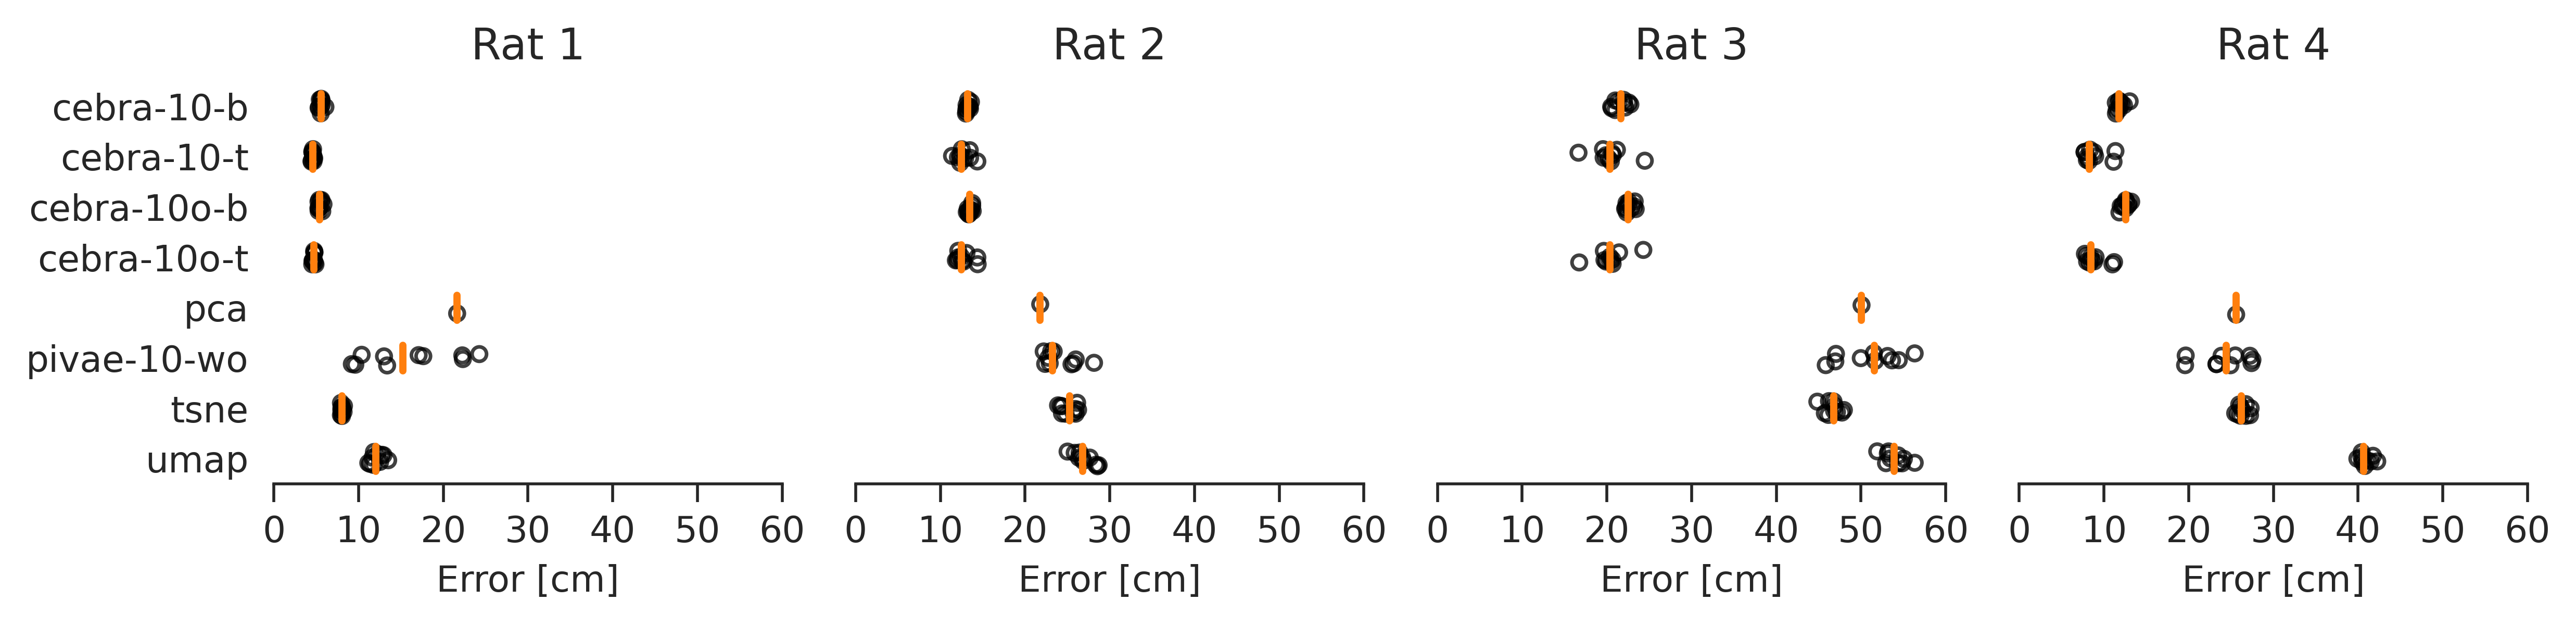

In [6]:
"""Decoding plot (Figure 2 and supplementary figure)"""

from matplotlib.markers import MarkerStyle
import warnings
import typing

def show_boxplot(df, metric, ax, labels = None, color = "C1"):

  sns.set_style("white")
  
  with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    sns.boxplot(
        data = df,
        y = 'method',
        x = metric,
        orient = 'h',
        order = labels, #unique(labels.values()),
        #hue = "rat",
        width = .5,
        color = 'k',
        linewidth = 2,
        flierprops = dict(alpha = .5, markersize = 0, marker = '.', linewidth = 0),
        medianprops = dict(c = color, markersize = 0, marker = '.', linewidth = 2, solid_capstyle='round'),
        whiskerprops = dict(solid_capstyle='butt', linewidth = 0),
        #capprops = dict(c = 'C1', markersize = 0, marker = 'o', linewidth = 1),
        showbox=False, showcaps=False,
        #shownotches = True
        ax = ax,

    )
    marker_style = MarkerStyle("o", "none")
    
    sns.stripplot(
      data = df,
      y = 'method',
      x = metric,
      orient = 'h',
      size = 4,
      color = "black",
      order = labels,
      marker = marker_style,
      linewidth = 1,
      ax = ax,
      alpha = 0.75,
      jitter = 0.15,
      zorder = -1,
    )
    #sns.despine(left = True, ax = ax)
    #ax.get_legend().remove()
    ax.set_ylabel("")
    sns.despine(left = True, bottom = False, ax = ax)
    #ax.tick_params(axis = 'x', length = 2, colors = "black")
    ax.tick_params(
      axis='x',
      which='both',
      bottom=True,
      top=False,
      length = 5,
      labelbottom=True)
    return ax

def _add_value(df, **kwargs):
  for key, value in kwargs.items():
    df[key] = value
  return df

def join(results):
  return pd.concat([_add_value(df, method = key) for key, df in results.items()])

import seaborn as sns
import matplotlib.pyplot as plt

#idx = aggregated.sort_values("train", ascending = True).tail(1).set_index(group_keys).index
#best = df.set_index(group_keys).loc[idx]
#best = best.groupby(group_keys + ["seed"]).mean()
#best["train_consistency"] = best["train"]

metadata = [
  #("train", "Consistency across subjects", 100, "R² (%)", [0,25,50,75,100]),
  #("train_run_consistency", "Consistency across runs", 100, "R² (%)", [0,25,50,75,100]),
  #("test_total_r2", "Decoding (direction, position)", 100, "R² (%)", [-25,0,25,50,75,100]),
  ("test_position_error", "Decoding (positional error)", 100, "Error [cm]", [0, 10, 20, 30, 40, 50, 60]),
  #("test_position_error_svm", "Decoding (positional error)", 100, "Error [cm]", [0, 10, 20, 30, 40])
]

def plot_decoding_overview(results_best):
  
  results_ = join(results_best)
  fig, axes = plt.subplots(1, 4,figsize = (10, 2.5), dpi = 500, sharey = True, sharex = True)

  #label_order = tuple(results_best.keys())

  def _agg(v):
    return sum(v) / len(v)

  for metric_id, (metric, metric_name, scale, xlabel, xlim) in enumerate(metadata):
    #table = results_.reset_index(drop = True).groupby(["method", "animal", "seed"])[metric].agg(_agg).reset_index()
    #display(table)

    table = results_.reset_index(drop = True).pivot_table(
      metric,
      index = ["animal", "repeat"],
      columns = ["method"],
      aggfunc = list #lambda v : list(itertools.chain.from_iterable(v) if isinstance(v, list) else list(v))
    ).applymap(lambda v : list(itertools.chain.from_iterable(v) if isinstance(v[0], typing.Iterable) else v))\
    .groupby("animal", level = 0).agg(lambda v : np.stack(v).mean(0))

    #.applymap(lambda v : v)\
    #.groupby("animal", level = 0).agg(lambda v : np.stack(v).mean(0))
    #display(table.applymap(lambda a : a.shape))
    #display(table)
    #continue
    #cebra32 = pd.read_pickle("figure4_decoding_results.pkl")
    #table = pd.concat([table, cebra32], axis = 1)
    #display(table)
    for animal in table.index:
      df = table.loc[animal].reset_index()
      df.columns = 'method', 'metric'
      df = df.explode("metric")
      df["metric"] *= scale
      #df = df[df.method.apply(lambda v : "-1-" in v)]
      #print(df.method.value_counts())

      #display(df)

      label_order = sorted(tuple(df.method.unique()))

      #df = df[df.method.apply(lambda v : "cebra-t" in v)]
      show_boxplot(
        df = df,
        metric = "metric",
        ax = axes[animal], #, metric_id],
        #labels = label_order,
        color = "C2" if ("svm" in metric) else "C1"
      )
      ax = axes[animal]
      #sns.despine(ax = ax, trim = True, left = True)
      ax.set_xlabel(xlabel)
      ax.set_xticks(xlim)
      ax.spines['bottom'].set_bounds(min(xlim), max(xlim))

      #axes[0, metric_id].set_title(metric_name, fontsize = 10)
      #axes[animal, 0].set_ylabel(f"Rat {animal+1}")

      #ax.set_yticklabels([
      #  "CEBRA-Behavior",
      #  "pi-VAE, MCMC",
      #  "CEBRA-Time",
      #  "pi-VAE, kNN",
      #  "t-SNE",
      #  "UMAP",
      #  "PCA"
      #])
      ax.set_ylabel("")
      ax.set_title(f"Rat {animal+1}")

  plt.tight_layout()
  
plot_decoding_overview(results)